In [37]:
 #CNN

import os
import logging

import pandas as pd
import tensorflow.keras as keras

from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import plot_model

# Log setting
logging.basicConfig(format="%(asctime)s %(levelname)s %(message)s", datefmt="%H:%M:%S", level=logging.INFO)

# Change display.max_rows to show all features.
pd.set_option("display.max_rows", 85)


In [38]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report
from sklearn.preprocessing import MinMaxScaler


def preprocessing(df: pd.DataFrame) -> (np.ndarray, np.ndarray):
    # Shuffle the dataset
    df = df.sample(frac=1)

    # Split features and labels
    x = df.iloc[:, df.columns != 'Label']
    y = df[['Label']].to_numpy()

    # Scale the features between 0 ~ 1
    scaler = MinMaxScaler()
    x = scaler.fit_transform(x)

    return x, y


def reshape_dataset_cnn(x: np.ndarray) -> np.ndarray:
    # Add padding columns
    result = np.zeros((x.shape[0], 81))
    result[:, :-4] = x

    # Reshaping dataset
    result = np.reshape(result, (result.shape[0], 9, 9))
    result = result[..., tf.newaxis]
    return result


def plot_history(history: tf.keras.callbacks.History):
    # summarize history for accuracy
    plt.plot(history.history['sparse_categorical_accuracy'])
    plt.plot(history.history['val_sparse_categorical_accuracy'])
    plt.title('model2 accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model2 loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()


def evaluation(model: keras.Model, x_test: np.ndarray, y_test: np.ndarray):
    score = model.evaluate(x_test, y_test, verbose=False)
    logging.info('Evaluation:\nLoss: {}\nAccuracy : {}\n'.format(score[0], score[1]))

    # F1 score
    y_pred = model.predict(x_test, batch_size=1024, verbose=False)
    y_pred = np.argmax(y_pred, axis=1)

    logging.info("\n{}".format(classification_report(y_test, y_pred)))

In [39]:
from keras import layers, models, callbacks

def create_cnn_model() -> models.Model:
    # Creating layers
    inputs = layers.Input(shape=(9, 9, 1))
    x = layers.Conv2D(120, 2, activation='relu', padding="same")(inputs)
    x = layers.Conv2D(60, 3, activation='relu', padding="same")(x)
    x = layers.Conv2D(30, 4, activation='relu', padding="same")(x)
    x = layers.Flatten()(x)
    outputs = layers.Dense(15, activation='softmax')(x)
    cnn_model = models.Model(inputs=inputs, outputs=outputs, name='cnn')

    # Compile layers
    cnn_model.compile(loss='sparse_categorical_crossentropy',
                      metrics=['sparse_categorical_accuracy'],
                      optimizer='adam')

    return cnn_model







In [40]:
# Create model
model = create_cnn_model()
logging.info(model.summary())

Model: "cnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 9, 9, 1)]         0         
                                                                 
 conv2d_9 (Conv2D)           (None, 9, 9, 120)         600       
                                                                 
 conv2d_10 (Conv2D)          (None, 9, 9, 60)          64860     
                                                                 
 conv2d_11 (Conv2D)          (None, 9, 9, 30)          28830     
                                                                 
 flatten_3 (Flatten)         (None, 2430)              0         
                                                                 
 dense_3 (Dense)             (None, 15)                36465     
                                                                 
Total params: 130,755
Trainable params: 130,755
Non-trainable p

11:21:52 INFO None


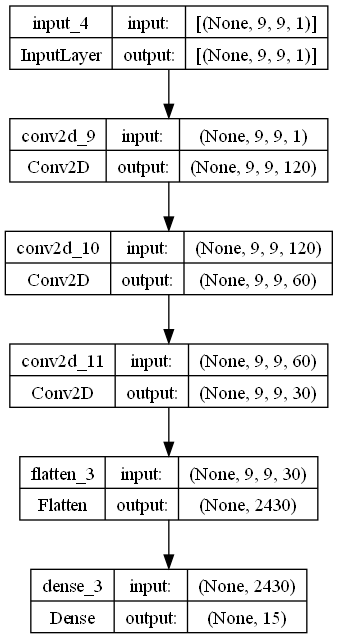

In [41]:
plot_model(model, show_shapes=True)


In [42]:
MODEL_DIR_PATH= r"C:\Users\ASUS\Documents\Projet_P2M"
PROCESSED_DIR_PATH=r"C:\Users\ASUS\Documents\Projet_P2M"

In [43]:
# Checkpoint
cp_path = os.path.join(MODEL_DIR_PATH, "5_2_cnn_weights-improvement-{epoch:02d}-{val_sparse_categorical_accuracy:.2f}.hdf5")
checkpoint = ModelCheckpoint(cp_path, monitor='val_sparse_categorical_accuracy', verbose=1,
                             save_best_only=True, mode='max')
callbacks_list = [checkpoint]

# Training
df = pd.read_csv(os.path.join(PROCESSED_DIR_PATH, 'train_data.csv'), skipinitialspace=True)
logging.info("Class distribution\n{}".format(df.Label.value_counts()))


11:21:57 INFO Class distribution
0    199876
3    184099
7    127043
1    102420
2      8234
6      6348
8      4718
5      4637
4      4399
Name: Label, dtype: int64


In [44]:

X, Y = preprocessing(df)
del df
X = reshape_dataset_cnn(X)


In [45]:
from sklearn.model_selection import train_test_split

early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)


In [46]:
x_train, x_val, y_train, y_val = train_test_split(X, Y, test_size=0.1, random_state=42)


In [47]:

logging.info("*** TRAINING START ***")

# Train the model with data augmentation and early stopping
history = model.fit(x_train, y_train, validation_data=(x_val, y_val),
                        batch_size=1024, epochs=20, callbacks=[early_stopping],verbose=True)

11:22:01 INFO *** TRAINING START ***


Epoch 1/20
565/565 [==============================] - 298s 525ms/step - loss: 0.3372 - sparse_categorical_accuracy: 0.8940 - val_loss: 0.1922 - val_sparse_categorical_accuracy: 0.9233
Epoch 2/20
565/565 [==============================] - 258s 457ms/step - loss: 0.1248 - sparse_categorical_accuracy: 0.9604 - val_loss: 0.1294 - val_sparse_categorical_accuracy: 0.9577
Epoch 3/20
565/565 [==============================] - 254s 449ms/step - loss: 0.0893 - sparse_categorical_accuracy: 0.9719 - val_loss: 0.0773 - val_sparse_categorical_accuracy: 0.9763
Epoch 4/20
565/565 [==============================] - 257s 456ms/step - loss: 0.0625 - sparse_categorical_accuracy: 0.9826 - val_loss: 0.0529 - val_sparse_categorical_accuracy: 0.9859
Epoch 5/20
565/565 [==============================] - 273s 482ms/step - loss: 0.0482 - sparse_categorical_accuracy: 0.9878 - val_loss: 0.0495 - val_sparse_categorical_accuracy: 0.9875
Epoch 6/20
565/565 [==============================] - 262s 463ms/step - loss: 0.

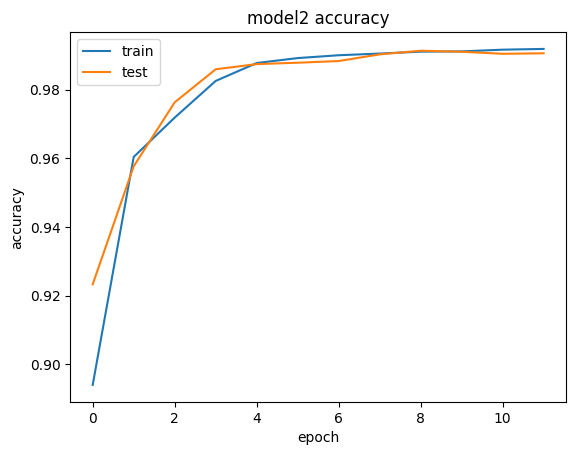

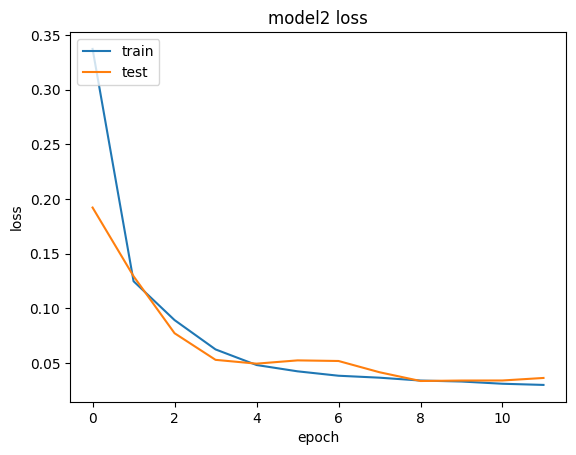

In [48]:

# Save the model
model.save(os.path.join(MODEL_DIR_PATH, "06_cnn.h5"))

plot_history(history)

In [1]:
# Evaluation

df = pd.read_csv(os.path.join(PROCESSED_DIR_PATH, 'test_data.csv'), skipinitialspace=True)

logging.info("Class distribution\n{}".format(df.Label.value_counts()))






NameError: name 'pd' is not defined

: 

In [50]:
X, Y = preprocessing(df)
del df
X = reshape_dataset_cnn(X)
evaluation(model, X, Y)

12:14:45 INFO Evaluation:
Loss: 0.07219468802213669
Accuracy : 0.9836578369140625

12:14:55 INFO 
              precision    recall  f1-score   support

           0       0.97      0.98      0.98     49969
           1       0.99      1.00      1.00     25605
           2       0.99      0.97      0.98      2059
           3       0.99      1.00      1.00     46025
           4       0.94      0.99      0.96      1100
           5       0.98      0.94      0.96      1159
           6       1.00      0.99      0.99      1587
           7       0.98      1.00      0.99     31761
           8       0.38      0.00      0.01      1179

    accuracy                           0.98    160444
   macro avg       0.91      0.87      0.87    160444
weighted avg       0.98      0.98      0.98    160444



12:16:36 INFO Evaluation:
Loss: 0.0721946433186531
Accuracy: 0.9836578369140625

12:16:46 INFO 
              precision    recall  f1-score   support

           0       0.97      0.98      0.98     49969
           1       0.99      1.00      1.00     25605
           2       0.99      0.97      0.98      2059
           3       0.99      1.00      1.00     46025
           4       0.94      0.99      0.96      1100
           5       0.98      0.94      0.96      1159
           6       1.00      0.99      0.99      1587
           7       0.98      1.00      0.99     31761
           8       0.38      0.00      0.01      1179

    accuracy                           0.98    160444
   macro avg       0.91      0.87      0.87    160444
weighted avg       0.98      0.98      0.98    160444



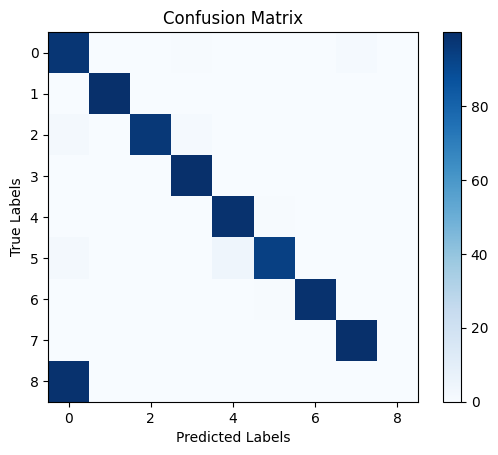

In [52]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def evaluation(model: keras.Model, x_test: np.ndarray, y_test: np.ndarray):
    score = model.evaluate(x_test, y_test, verbose=False)
    logging.info('Evaluation:\nLoss: {}\nAccuracy: {}\n'.format(score[0], score[1]))

    # F1 score
    y_pred = model.predict(x_test, batch_size=1024, verbose=False)
    y_pred = np.argmax(y_pred, axis=1)
 
    logging.info("\n{}".format(classification_report(y_test, y_pred)))

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100  # Compute percentages

    # Plotting the confusion matrix
    plt.imshow(cm_percent, cmap='Blues')
    plt.title('Confusion Matrix')
    plt.colorbar()
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

X, Y = preprocessing(df)
del df
X = reshape_dataset_cnn(X)
evaluation(model, X, Y)


In [ ]:
early_stopping

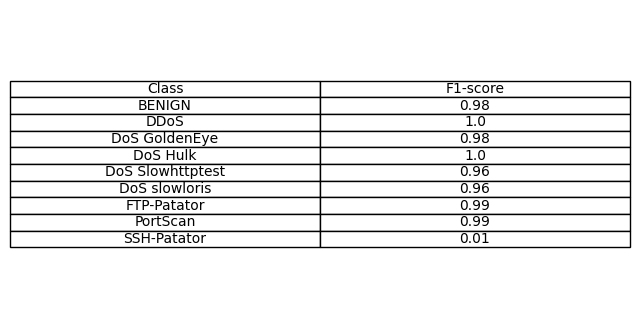

: 

In [56]:
import pandas as pd
import matplotlib.pyplot as plt
classes=['BENIGN', 'DDoS', 'DoS GoldenEye', 'DoS Hulk', 'DoS Slowhttptest',
        'DoS slowloris', 'FTP-Patator', 'PortScan', 'SSH-Patator']
# Assuming you have saved the table as a DataFrame called 'result'
result_data = {
    'Class': classes,
    'F1-score': [0.98, 1.00, 0.98, 1.00, 0.96, 0.96, 0.99, 0.99, 0.01],
}

# Create the DataFrame
result_df = pd.DataFrame(result_data)

# Plot the table
plt.figure(figsize=(8, 4))
plt.table(cellText=result_df.values, colLabels=result_df.columns, cellLoc='center', loc='center')
plt.axis('off')
plt.show() 